# Testing detectron2 models from the zoo on VDR

In [1]:
%matplotlib inline

import json
import random
from pathlib import Path
from functools import partial
from itertools import zip_longest

import cv2
import numpy as np
import detectron2.config
import detectron2.engine
import detectron2.model_zoo
import detectron2.structures
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from PIL import Image, UnidentifiedImageError, ExifTags, ImageOps
from loguru import logger
from IPython.display import display, Markdown

random.seed(42)

## Detectron2 models

Detectron 2 models from the model zoo, and the object categories they are traied to recognize.

In [2]:
lvis_things = MetadataCatalog.get('lvis_v0.5_train').thing_classes

In [3]:
models = {}
metadata = {}

for name, cfg_path in {
    'coco-detection': 'COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml',
    'coco-instance': 'COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml',
    'coco-panoptic': 'COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml',
    'lvis-instance': 'LVIS-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_1x.yaml',
}.items():
    cfg = detectron2.config.get_cfg()
    cfg.merge_from_file(detectron2.model_zoo.get_config_file(cfg_path))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.WEIGHTS=detectron2.model_zoo.get_checkpoint_url(cfg_path)
    models[name] = detectron2.engine.DefaultPredictor(cfg)
    metadata[name] = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

In [4]:
print('detection', 'instance', '        panoptic', sep=' '*7)
print('things', 'things', 'things', 'stuff', sep=' '*10)
print('-'*60)
for dt, it, pt, ps in zip_longest(
    sorted(metadata['coco-detection'].thing_classes),
    sorted(metadata['coco-instance'].thing_classes),
    sorted(metadata['coco-panoptic'].thing_classes),
    sorted(metadata['coco-panoptic'].stuff_classes),
    fillvalue=''
):
    print(f'{dt:<15} {it:<15} {pt:<15} {ps:<15}')

detection       instance               panoptic
things          things          things          stuff
------------------------------------------------------------
airplane        airplane        airplane        banner         
apple           apple           apple           blanket        
backpack        backpack        backpack        bridge         
banana          banana          banana          building       
baseball bat    baseball bat    baseball bat    cabinet        
baseball glove  baseball glove  baseball glove  cardboard      
bear            bear            bear            ceiling        
bed             bed             bed             counter        
bench           bench           bench           curtain        
bicycle         bicycle         bicycle         dirt           
bird            bird            bird            door-stuff     
boat            boat            boat            fence          
book            book            book            floor          
bottl

In [5]:
lvis = set(t.replace('_', ' ') for t in metadata['lvis-instance'].thing_classes)
coco_det = set(t.replace('_', ' ') for t in metadata['coco-detection'].thing_classes)
coco_pan = set.union(
    set(t.replace('_', ' ') for t in metadata['coco-panoptic'].thing_classes),
    set(t.replace('_', ' ') for t in metadata['coco-panoptic'].stuff_classes)
)

print(f'LVIS: {len(lvis)}\n'
      f'COCO-PAN: {len(coco_pan)}\n'
      f'COCO-DET: {len(coco_det)}')

LVIS: 1230
COCO-PAN: 134
COCO-DET: 80


COCO DET is fully contained in COCO PAN

In [6]:
coco_det.issubset(coco_pan)

True

LVIS contains 57 objects from COCO DET

In [7]:
len(set.intersection(lvis, coco_det))

57

LVIS also contains 7 objects from COCO PAN that are not in COCO DET

In [8]:
set.intersection(lvis, coco_pan) - coco_det

{'banner', 'blanket', 'cabinet', 'curtain', 'pillow', 'table', 'towel'}

## Visual relationship detection dataset

In detectron2 format for object detection.

In [9]:
exif_tags = {name: id for id, name in ExifTags.TAGS.items()}
print(exif_tags['Orientation'])

274


In [10]:
vrd_dir = Path('../../data/vrd/raw')

def y1y2x1x2_to_x1y1x2y2(y1y2x1x2):
    y1, y2, x1, x2 = y1y2x1x2
    return x1, y1, x2, y2

def get_exif_orientation(img: Image):
    orientation = img.getexif().get(274)
    return {
        2: Image.FLIP_LEFT_RIGHT,
        3: Image.ROTATE_180,
        4: Image.FLIP_TOP_BOTTOM,
        5: Image.TRANSPOSE,
        6: Image.ROTATE_270,
        7: Image.TRANSVERSE,
        8: Image.ROTATE_90,
    }.get(orientation)

def get_vrd_dicts(vrd_dir, split):
    with vrd_dir.joinpath(f'annotations_{split}.json').open() as f:
        annotations = json.load(f)
    
    samples = []
    for filename, relations in annotations.items():
        img_path = vrd_dir.joinpath(f'sg_{split}_images').joinpath(filename)
        try:
            with Image.open(img_path.as_posix()) as img:
                width, height = img.size
                exif_orientation = get_exif_orientation(img)
        except (FileNotFoundError, UnidentifiedImageError):
            logger.warning(f"{split.capitalize()} image not found/invalid {img_path.name}")
            continue
        
        if exif_orientation is not None:
            logger.warning(f'{split.capitalize()} image {img_path.name} (id {len(samples)}) '
                           f'has an EXIF orientation tag, '
                           f'check the corresponding boxes!')
        
        sample = {
            "file_name": img_path.as_posix(),
            'image_id': len(samples),
            'width': width,
            'height': height,
        }

        # Set to filter duplicates
        instances = set()
        for r in relations:
            for so in ('subject', 'object'):
                instances.add((
                    r[so]['category'], 
                    y1y2x1x2_to_x1y1x2y2(r[so]['bbox'])
                ))

        sample['annotations'] = [{
            'category_id': o[0],
            'bbox': o[1],
            'bbox_mode': detectron2.structures.BoxMode.XYXY_ABS,
        } for o in instances]

        samples.append(sample)
        
    return samples

with vrd_dir.joinpath('objects.json').open() as f:
    objects = json.load(f)

for split in ["train", "val"]:
    DatasetCatalog.register(f"vrd_{split}", partial(get_vrd_dicts, vrd_dir, split))
    MetadataCatalog.get(f"vrd_{split}").set(thing_classes=objects)

datasets = {}
datasets['train'] = get_vrd_dicts(vrd_dir, "train")
datasets['test'] = get_vrd_dicts(vrd_dir, "test")
metadata['vrd'] = MetadataCatalog.get("vrd_train")
vrd = set(t.replace('_', ' ') for t in metadata['vrd'].thing_classes)

2020-02-20 20:14:55.659 | WARNING  | __main__:get_vrd_dicts:35 - Test image 194654941_052c0bd67f_o.jpg (id 6) has an EXIF orientation tag, check the corresponding boxes!
2020-02-20 20:14:55.826 | WARNING  | __main__:get_vrd_dicts:31 - Test image not found/invalid 4392556686_44d71ff5a0_o.jpg


These objects are unique to VRD and can not be found in LVIS nor COCO DET/PAN

In [11]:
vrd - lvis - coco_pan

{'bag',
 'bike',
 'box',
 'bush',
 'computer',
 'engine',
 'face',
 'glasses',
 'hand',
 'hydrant',
 'jeans',
 'luggage',
 'monitor',
 'pants',
 'phone',
 'plane',
 'plant',
 'post',
 'ramp',
 'shoes',
 'shorts',
 'street',
 'tower',
 'trees',
 'van'}

In [12]:
for d in (
    [datasets['train'][259], datasets['train'][703], datasets['train'][1147], datasets['train'][1839]] + 
    random.sample(datasets['train'], 3)
):
    display(Markdown('Image: ' + Path(d["file_name"]).name))
    
    img_rgb = Image.open(d["file_name"]).convert('RGB')
    W = img_rgb.size[0] // 2
    H = img_rgb.size[1] // 2
    img_rgb = np.asarray(img_rgb)
    img_bgr = np.asarray(img_rgb)[:,:,::-1]
    
    img_out = Image.new('RGB', (2*W + 10, 3*H + 20))
    
    # Ground-truth
    visualizer = Visualizer(img_rgb, metadata=metadata['vrd'], scale=.5)
    vis = visualizer.draw_dataset_dict(d)
    img_out.paste(Image.fromarray(vis.get_image()), (W // 2 + 5, 0))
    
    # COCO object detection
    outputs = models['coco-detection'](img_bgr)
    visualizer = Visualizer(img_rgb, metadata=metadata['coco-detection'], scale=.5)
    vis = visualizer.draw_instance_predictions(outputs['instances'].to('cpu'))
    img_out.paste(Image.fromarray(vis.get_image()), (0, H + 10))
    
    # COCO instance segmentation
    outputs = models['coco-instance'](img_bgr)
    visualizer = Visualizer(img_rgb, metadata=metadata['coco-instance'], scale=.5)
    vis = visualizer.draw_instance_predictions(outputs['instances'].to('cpu'))
    img_out.paste(Image.fromarray(vis.get_image()), (W + 10, H + 10))
    
    # COCO panoptic segmentation
    outputs = models['coco-panoptic'](img_bgr)
    visualizer = Visualizer(img_rgb, metadata=metadata['coco-panoptic'], scale=.5)
    vis = visualizer.draw_panoptic_seg_predictions(outputs['panoptic_seg'][0].to('cpu'), outputs['panoptic_seg'][1])
    img_out.paste(Image.fromarray(vis.get_image()), (0, 2*H + 20))
    
    # LVIS instance segmentation
    outputs = models['lvis-instance'](img_bgr)
    visualizer = Visualizer(img_rgb, metadata=metadata['lvis-instance'], scale=.5)
    vis = visualizer.draw_instance_predictions(outputs['instances'].to('cpu'))
    img_out.paste(Image.fromarray(vis.get_image()), (W + 10, 2*H + 20))
    
    # Prevent embedding these images in the notebook
    save_path = Path(d["file_name"]).with_suffix('').with_suffix('.d2_zoo.jpg').name
    img_out.save(save_path, 'JPEG')
    display(Markdown(f'![{d["file_name"]}]({save_path})'))
    display(Markdown('---'))

Image: 3802901524_68f0bcbef4_o.jpg

![../../data/vrd/raw/sg_train_images/3802901524_68f0bcbef4_o.jpg](3802901524_68f0bcbef4_o.d2_zoo.jpg)

---

Image: 4022354319_b1f63bf858_b.jpg

![../../data/vrd/raw/sg_train_images/4022354319_b1f63bf858_b.jpg](4022354319_b1f63bf858_b.d2_zoo.jpg)

---

Image: 3385172794_f1a5d0903c_b.jpg

![../../data/vrd/raw/sg_train_images/3385172794_f1a5d0903c_b.jpg](3385172794_f1a5d0903c_b.d2_zoo.jpg)

---

Image: 8093545484_7b9c00966d_b.jpg

![../../data/vrd/raw/sg_train_images/8093545484_7b9c00966d_b.jpg](8093545484_7b9c00966d_b.d2_zoo.jpg)

---

Image: 6086004293_9ee71c012e_b.jpg

![../../data/vrd/raw/sg_train_images/6086004293_9ee71c012e_b.jpg](6086004293_9ee71c012e_b.d2_zoo.jpg)

---

Image: 8465079679_58ae9428d1_b.jpg

![../../data/vrd/raw/sg_train_images/8465079679_58ae9428d1_b.jpg](8465079679_58ae9428d1_b.d2_zoo.jpg)

---

Image: 9868723753_7b34d3cf05_b.jpg

![../../data/vrd/raw/sg_train_images/9868723753_7b34d3cf05_b.jpg](9868723753_7b34d3cf05_b.d2_zoo.jpg)

---

## Problems

This image has an EXIF orientation tag.

PIL loads the image _as-is_ without considering the tag.

8


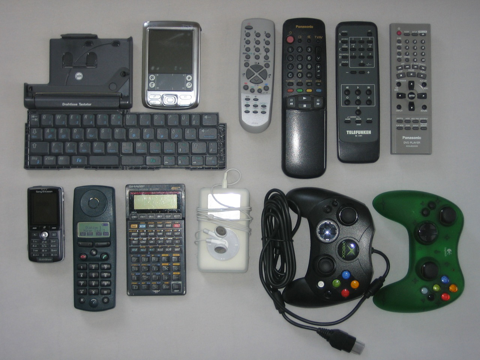

In [13]:
d = datasets['test'][6]

i=Image.open(d['file_name'])
print(i.getexif().get(exif_tags['Orientation']))
ii = i.copy()
ii.thumbnail((480, 480))
ii

PIL also supports rotating the image according to the orientation, which is what detectron does internally.

/home/federico/anaconda3/envs/eccv/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/home/federico/anaconda3/envs/eccv/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))


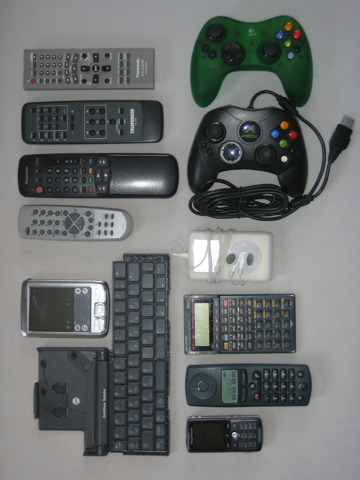

In [14]:
ii=ImageOps.exif_transpose(i.copy())
ii.thumbnail((480,480))
ii

OpenCV instead automatically rotates the image when loading.

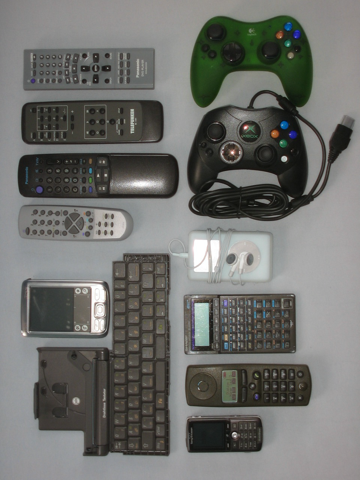

In [15]:
img_cv2 = Image.fromarray(cv2.imread(d['file_name']))
img_cv2.thumbnail((480, 480))
img_cv2

However, the annotations in the json file are clearly made for the non-rotated version of the image.

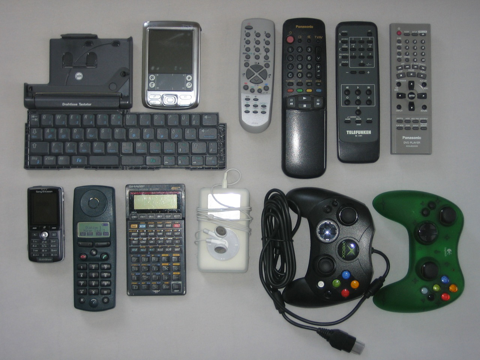

In [16]:
orig = Image.open(d['file_name'])
orig.thumbnail((480,480))
orig

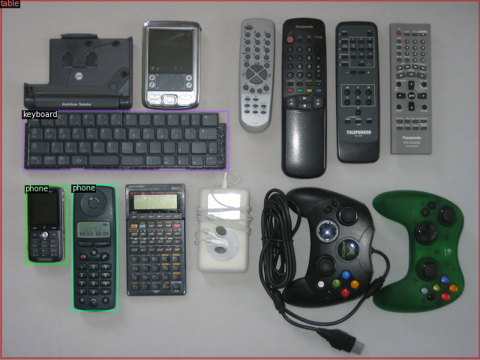

In [17]:
orig = Image.open(d['file_name'])
visualizer = Visualizer(orig, metadata=metadata['vrd'], scale=.5)
vis = visualizer.draw_dataset_dict(d)
orig = Image.fromarray(vis.get_image())
orig.thumbnail((480, 480))
display(orig)

In [18]:
def show_exif(d):
    out = Image.new('RGB', (480*2 + 5, 480))
    out.paste((255,255,255), (482, 0, 483, 480))
    
    orig = Image.open(d['file_name'])
    exif_orientation = orig.getexif().get(exif_tags['Orientation'])
    visualizer = Visualizer(orig, metadata=metadata['vrd'], scale=.5)
    vis = visualizer.draw_dataset_dict(d)
    orig = Image.fromarray(vis.get_image())
    orig.thumbnail((480, 480))
    out.paste(orig, (240-orig.size[0] // 2, 240-orig.size[1] // 2))
    
    orig = Image.open(d['file_name'])
    rot = ImageOps.exif_transpose(orig.copy())
    visualizer = Visualizer(rot, metadata=metadata['vrd'], scale=.5)
    vis = visualizer.draw_dataset_dict(d)
    rot = Image.fromarray(vis.get_image())
    rot.thumbnail((480, 480))
    out.paste(rot, (480 + 5 + 240 - rot.size[0] // 2, 240-rot.size[1] // 2))
    
    display(Markdown('Not rotated | Rotated'))
    
    save_path = Path(d["file_name"]).with_suffix('').with_suffix('.gt_boxes.jpg').name
    out.save(save_path, 'JPEG')
    display(Markdown(f'![{d["file_name"]}]({save_path})'))
    display(Markdown('---'))
    
show_exif(datasets['test'][6])

Not rotated | Rotated

![../../data/vrd/raw/sg_test_images/194654941_052c0bd67f_o.jpg](194654941_052c0bd67f_o.gt_boxes.jpg)

---